<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Tutorial - Sentinel-2 data STAC access and time series processing"<br>
    description: "This is a tutorial within the second theme of Module 1 of the E-TRAINEE course."<br>
    lastUpdate: 2023-07-13<br>
    authors: Andreas Mayr<br>
</details>

# Sentinel-2 data STAC access and time series processing

This Notebook illustrates how to query and download Sentinel-2 satellite imagery from Amazon Web Service (AWS) using a SpatioTemporal Asset Catalog (STAC). Furthermore, it shows how to work with the data using `xarray` (which was introduced in a tutorial in theme 1), and how to perform tasks like subsetting, cloud masking, spectral index calculation, temporal aggregation, and trend analysis. A few simple processing steps let you explore the development of the Normalized Difference Vegetation Index (NDVI) in spring and summer, including e.g. the seasonal greening of mountain grasslands.

The Notebook heavily relies on the Python packages [pystac-client](https://pystac-client.readthedocs.io/en/stable/), [stackstac](https://stackstac.readthedocs.io/en/latest/), and [xarray](https://docs.xarray.dev/en/stable/). These packages are contained in the requirements file provided for the course. Please see the instructions on the [software page](https://3dgeo-heidelberg.github.io/etrainee/software/software_python.html) for setting up a Conda environment based on this file.

Parts of the Notebook use code from a tutorial provided [here](https://stackstac.readthedocs.io/en/latest/basic.html).

## Query data via STAC

Import packages.

In [2]:
import pystac_client
import stackstac
import pyproj
import xarray
import rioxarray

Define a point of interest to intersect our query.

In [4]:
lon, lat = 11.39, 47.26     # Innsbruck (Austria)

Use the pystac_client package and [element84](https://www.element84.com/earth-search/)’s search endpoint to look for items from the ```sentinel-s2-l2a-cogs``` collection on Amazon Web Service (AWS). As search criteria we use a maximum cloud cover (per scene) and a time period.

In [5]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [11]:
%%time                                  # See how fast the query is
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    query =  ['eo:cloud_cover<50'],
    datetime="2021-04-01/2021-08-31"
).get_all_items()
print(f'{len(items)} items found')      # How many items in the catalog match these criteria?

35 items found
CPU times: total: 78.1 ms
Wall time: 1.27 s


Use `stackstac` to turn those STAC items into a lazy xarray. Without specifying anything, this makes use of dask and reads the data in chunks, with one chunk shaped (1, 1, 1024, 1024) in the time, band, y, x dimensions (Read more about chunk sizes [here](https://docs.dask.org/en/latest/array-best-practices.html), [here](https://xcube.readthedocs.io/en/latest/overview.html#data-chunks), and [here](https://gallery.pangeo.io/repos/pangeo-data/landsat-8-tutorial-gallery/landsat8.html).). Using all the defaults, our data will be in its native coordinate reference system, at the finest resolution of all the assets.

In [12]:
%time stack = stackstac.stack(items)

CPU times: total: 78.1 ms
Wall time: 55.8 ms


Now print info about this xarray.DataArray called 'stack'. Note that everything has run quickly so far, despite the large data volume covered by our query. Up to now, we are only working with metadata, no download or processing of any pixel values.

In [13]:
stack

<xarray.DataArray 'stackstac-f79fa3e66612fef1b91622a0564184e4' (time: 35,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(35, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * time                        (time) datetime64[ns] 2021-04-01T10:27:39 ......
    id                          (time) <U24 'S2B_32TPT_20210401_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                           (y) float64 5.3e+06 5.3e+06 ... 5.19e+06
    sentinel:latitude_band      <U1 'T'
    ...                          ...
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None None 'coastal' ... None None
    center_wavelength           (band) object None None 0.4439 ... None None
    full_width_half_max         (band) object None None 0.027 ... None None None
    epsg                        int32 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5190240.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

We are only interested in a relatively small area around our main point of interest (defined above for intersection). So we convert the coordinates of this point into the native CRS of the satellite data, add a buffer and then use this rectangle to slice ("clip") the stacked array spatially.

In [14]:
x_utm, y_utm = pyproj.Proj(stack.crs)(lon, lat)     # Re-project the geographic point coordinates to the sat data CRS (i.e. EPSG:32632)
buffer = 5000  # meters

Now we have a much smaller DataArray (with 1000 by 1000 cells in x/y) called 'stack_aoi'.

In [15]:
stack_aoi = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
stack_aoi

<xarray.DataArray 'stackstac-f79fa3e66612fef1b91622a0564184e4' (time: 35,
                                                                band: 17,
                                                                y: 1000, x: 1000)>
dask.array<getitem, shape=(35, 17, 1000, 1000), dtype=float64, chunksize=(1, 1, 678, 610), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * time                        (time) datetime64[ns] 2021-04-01T10:27:39 ......
    id                          (time) <U24 'S2B_32TPT_20210401_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 6.758e+05 6.758e+05 ... 6.858e+05
  * y                           (y) float64 5.242e+06 5.242e+06 ... 5.232e+06
    sentinel:latitude_band      <U1 'T'
    ...                          ...
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None None 'coastal' ... None None
    center_wavelength           (band) object None None 0.4439 ... None None
    full_width_half_max         (band) object None None 0.027 ... None None None
    epsg                        int32 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5190240.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

We want only the four 10-m bands and the Scene Classification (SCL) layer.

In [16]:
stack_aoi = stack_aoi.sel(band = ['B02', 'B03', 'B04', 'B08', 'SCL'])
stack_aoi

<xarray.DataArray 'stackstac-f79fa3e66612fef1b91622a0564184e4' (time: 35,
                                                                band: 5,
                                                                y: 1000, x: 1000)>
dask.array<getitem, shape=(35, 5, 1000, 1000), dtype=float64, chunksize=(1, 1, 678, 610), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * time                        (time) datetime64[ns] 2021-04-01T10:27:39 ......
    id                          (time) <U24 'S2B_32TPT_20210401_0_L2A' ... 'S...
  * band                        (band) <U8 'B02' 'B03' 'B04' 'B08' 'SCL'
  * x                           (x) float64 6.758e+05 6.758e+05 ... 6.858e+05
  * y                           (y) float64 5.242e+06 5.242e+06 ... 5.232e+06
    sentinel:latitude_band      <U1 'T'
    ...                          ...
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'Band 2 (blue)' ... 'Scene Classi...
    common_name                 (band) object 'blue' 'green' 'red' 'nir' None
    center_wavelength           (band) object 0.4966 0.56 0.6645 0.8351 None
    full_width_half_max         (band) object 0.098 0.045 0.038 0.145 None
    epsg                        int32 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5190240.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

Now we trigger the stacking of these selected bands for our area-of-interest by calling `compute()`, i.e. we load the data into memory. This may take some minutes but then enables us to analyse and plot the data faster. Alternatively (also for larger datasets), we could continue with the lazy array and in subsequent steps only load what is needed.

In [20]:
%%time
data = stack_aoi.compute()

CPU times: total: 55 s
Wall time: 5min


In [21]:
data

<xarray.DataArray 'stackstac-f79fa3e66612fef1b91622a0564184e4' (time: 35,
                                                                band: 5,
                                                                y: 1000, x: 1000)>
array([[[[1.3129e+04, 1.2153e+04, 1.2209e+04, ..., 1.8400e+02,
          1.9900e+02, 1.8600e+02],
         [1.2824e+04, 1.3097e+04, 1.3017e+04, ..., 1.9100e+02,
          2.0500e+02, 2.0300e+02],
         [1.2417e+04, 1.3104e+04, 1.3577e+04, ..., 2.0500e+02,
          2.0700e+02, 2.0900e+02],
         ...,
         [2.1300e+02, 2.3700e+02, 4.7400e+02, ..., 1.5430e+03,
          1.9900e+03, 2.4620e+03],
         [2.1100e+02, 1.7800e+02, 2.8200e+02, ..., 1.8520e+03,
          1.8380e+03, 2.3080e+03],
         [3.2000e+02, 1.6200e+02, 1.9400e+02, ..., 1.9290e+03,
          1.5350e+03, 1.5050e+03]],

        [[1.3055e+04, 1.2049e+04, 1.2064e+04, ..., 1.7600e+02,
          2.1900e+02, 1.9800e+02],
         [1.2845e+04, 1.3066e+04, 1.2967e+04, ..., 1.8200e+02,
          2.7200e+02, 2.2100e+02],
         [1.2360e+04, 1.3113e+04, 1.3719e+04, ..., 2.1500e+02,
          2.6600e+02, 2.3100e+02],
...
         [2.5240e+03, 2.7640e+03, 2.4980e+03, ..., 3.4220e+03,
          3.8840e+03, 4.8160e+03],
         [2.6360e+03, 2.5460e+03, 2.4480e+03, ..., 3.0460e+03,
          3.0180e+03, 3.1860e+03],
         [2.0360e+03, 2.0800e+03, 2.3320e+03, ..., 3.1400e+03,
          3.1740e+03, 2.4180e+03]],

        [[3.0000e+00, 3.0000e+00, 3.0000e+00, ..., 4.0000e+00,
          4.0000e+00, 4.0000e+00],
         [3.0000e+00, 3.0000e+00, 3.0000e+00, ..., 4.0000e+00,
          4.0000e+00, 4.0000e+00],
         [2.0000e+00, 2.0000e+00, 2.0000e+00, ..., 4.0000e+00,
          4.0000e+00, 4.0000e+00],
         ...,
         [4.0000e+00, 4.0000e+00, 4.0000e+00, ..., 4.0000e+00,
          4.0000e+00, 4.0000e+00],
         [4.0000e+00, 4.0000e+00, 4.0000e+00, ..., 4.0000e+00,
          4.0000e+00, 4.0000e+00],
         [4.0000e+00, 4.0000e+00, 4.0000e+00, ..., 4.0000e+00,
          4.0000e+00, 4.0000e+00]]]])
Coordinates: (12/26)
  * time                        (time) datetime64[ns] 2021-04-01T10:27:39 ......
    id                          (time) <U24 'S2B_32TPT_20210401_0_L2A' ... 'S...
  * band                        (band) <U8 'B02' 'B03' 'B04' 'B08' 'SCL'
  * x                           (x) float64 6.758e+05 6.758e+05 ... 6.858e+05
  * y                           (y) float64 5.242e+06 5.242e+06 ... 5.232e+06
    sentinel:latitude_band      <U1 'T'
    ...                          ...
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'Band 2 (blue)' ... 'Scene Classi...
    common_name                 (band) object 'blue' 'green' 'red' 'nir' None
    center_wavelength           (band) object 0.4966 0.56 0.6645 0.8351 None
    full_width_half_max         (band) object 0.098 0.045 0.038 0.145 None
    epsg                        int32 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5190240.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

Try plotting some data (July 2021 only):

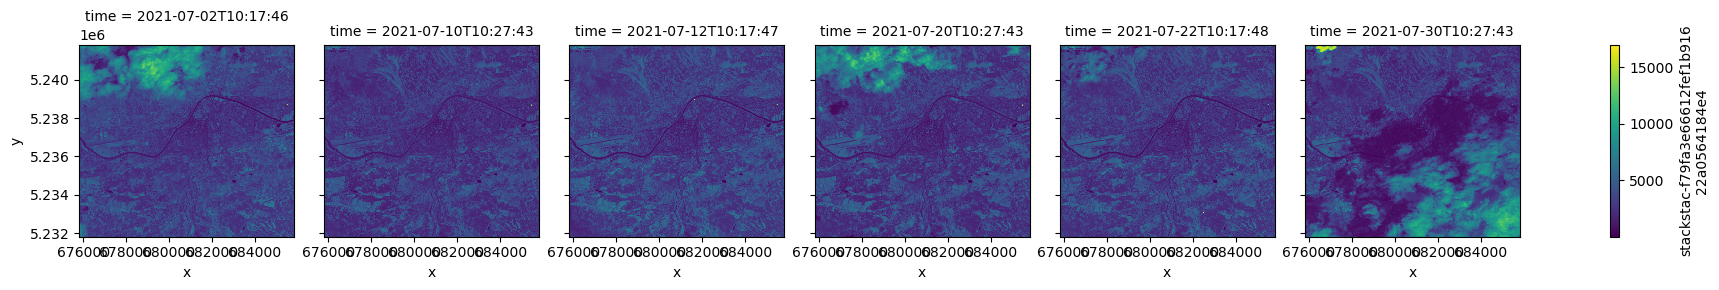

In [22]:
data.sel(band='B08').sel(time='2021-07').plot.imshow(col='time')

## Cloud masking

We use the [scene classification](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) provided by ESA via the SCL band as a simple (but not the best) means to mask clouds and other problematic pixels.

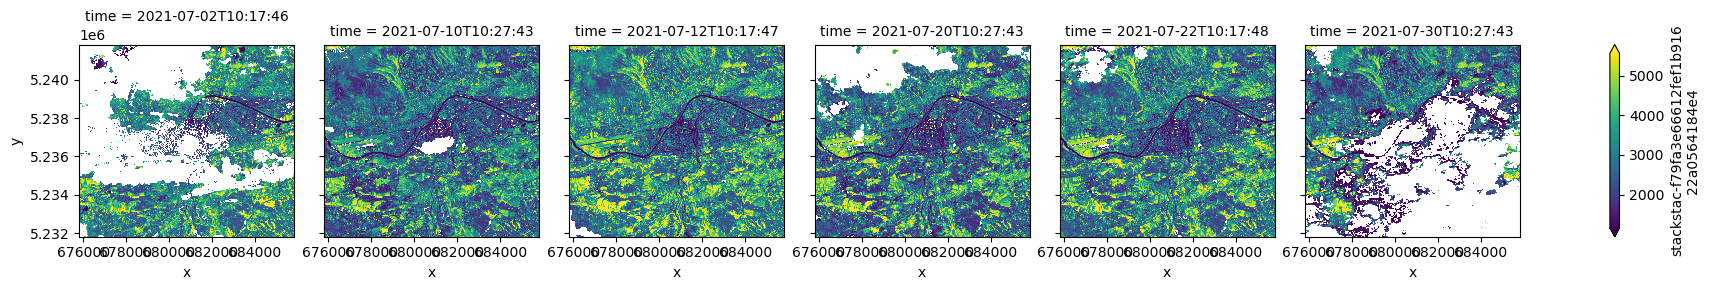

In [23]:
import dask.array as da

scl = data.sel(band=["SCL"])
# Sentinel-2 Scene Classification Map: nodata, saturated/defective, dark, cloud shadow, cloud med. prob., cloud high prob., cirrus
invalid_data = da.isin(scl, [0, 1, 2, 3, 8, 9, 10])
valid_data = data.where(~invalid_data)
# Show some of the cloud masked data
valid_data.sel(band='B08').sel(time='2021-07').plot.imshow(col='time', robust=True)

Let's show cloud-masked RGB true color composites.

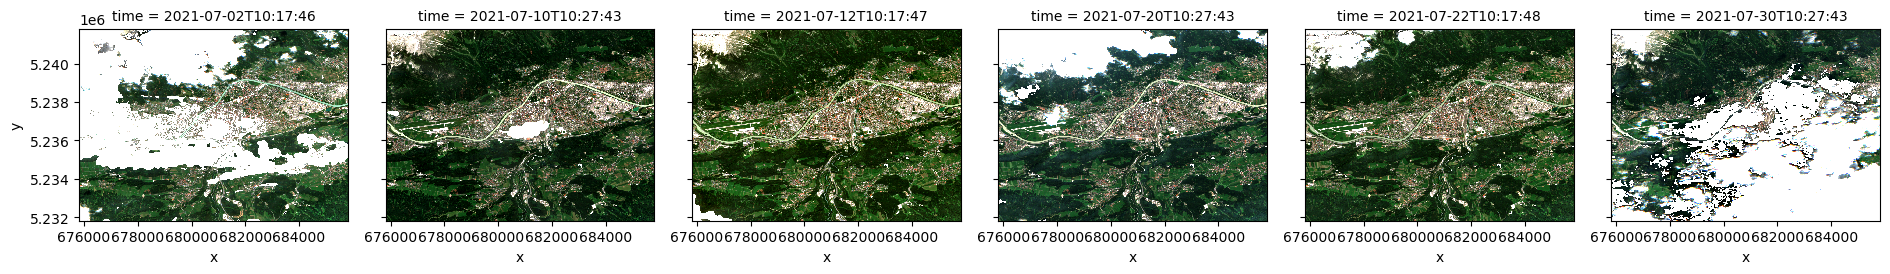

In [24]:
valid_data.sel(time='2021-07').sel(band=['B04', 'B03', 'B02']).plot.imshow(col='time', robust=True)

## Spectral index calculation (NDVI)

We calculate the Normalized Difference Vegetation Index ([NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)). If you need more indices consider the [Spyndex](https://spyndex.readthedocs.io/) package.

In [25]:
# Compute the NDVI from the NIR (B8) and red (B4) bands
nir, red = valid_data.sel(band='B08'), valid_data.sel(band='B04')
NDVI = (nir - red) / (nir + red)

NDVI is a new DataArray. If you want to select the NDVI raster closest to a specific date and export it as a GeoTIFF, just run this line:

In [26]:
NDVI.sel(time='2021-07-15', method='nearest').rio.to_raster("C:\work\etrainee\stac_exports/S2-NDVI_midjuly.tif")

Let's plot one month of NDVI rasters.

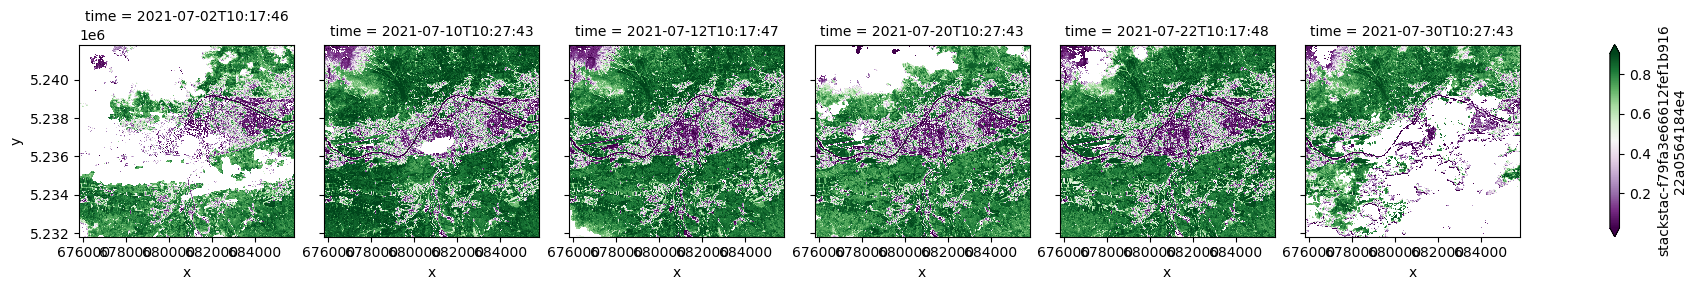

In [27]:
NDVI.sel(time='2021-07').plot.imshow(col='time', cmap="PRGn", robust=True)

## Time series operations

### Interpolate missing values

Let's fill missing values by (linear) interpolation between observations.

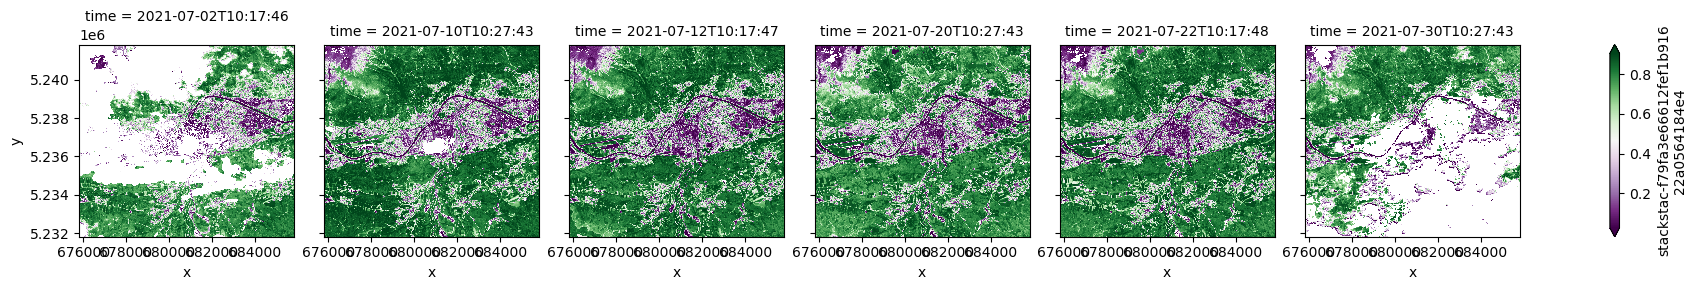

In [28]:
NDVI.sel(time='2021-07').interpolate_na(dim='time').plot(col='time', cmap="PRGn", robust=True)

### Resampling

We resample/aggregate to one month temporal resolution by computing the mean for each month. Other aggregations (e.g. maximum) can be achieved similarly. Note how we can absolutely define the range of values to be displayed (important for visual comparisons).

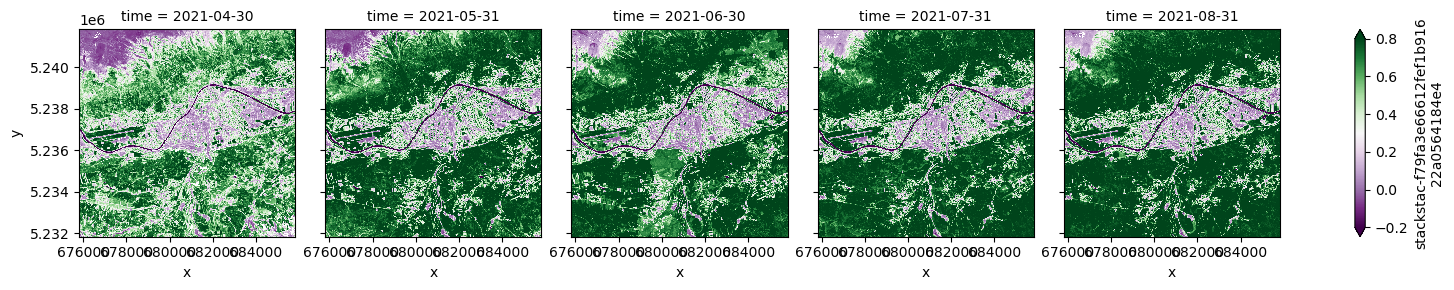

In [35]:
NDVI.resample(time='1M').mean().plot(col='time', cmap="PRGn", vmin=-0.2, vmax=0.8)

### Trend analysis

The [xarrayutils](https://xarrayutils.readthedocs.io/en/latest/api.html#xarrayutils.utils.linear_trend) package contains a convenient `linear_trend()` function. We use this to fit a linear least-squares trendline to our NDVI time series.

In [38]:
from xarrayutils import linear_trend
NDVI_regressed = linear_trend(NDVI, 'time')

Plot maps (with default colormaps) for the resulting slope of the estimated [linear trend](https://en.wikipedia.org/wiki/Linear_trend_estimation) along with [r-value](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (Pearson correlation coefficient), [p-value](https://en.wikipedia.org/wiki/P-value) (for a hypothesis test whose null hypothesis is that the slope is zero), and standard error (of the estimated slope). We use matplotlib syntax and functions to configure the plot.

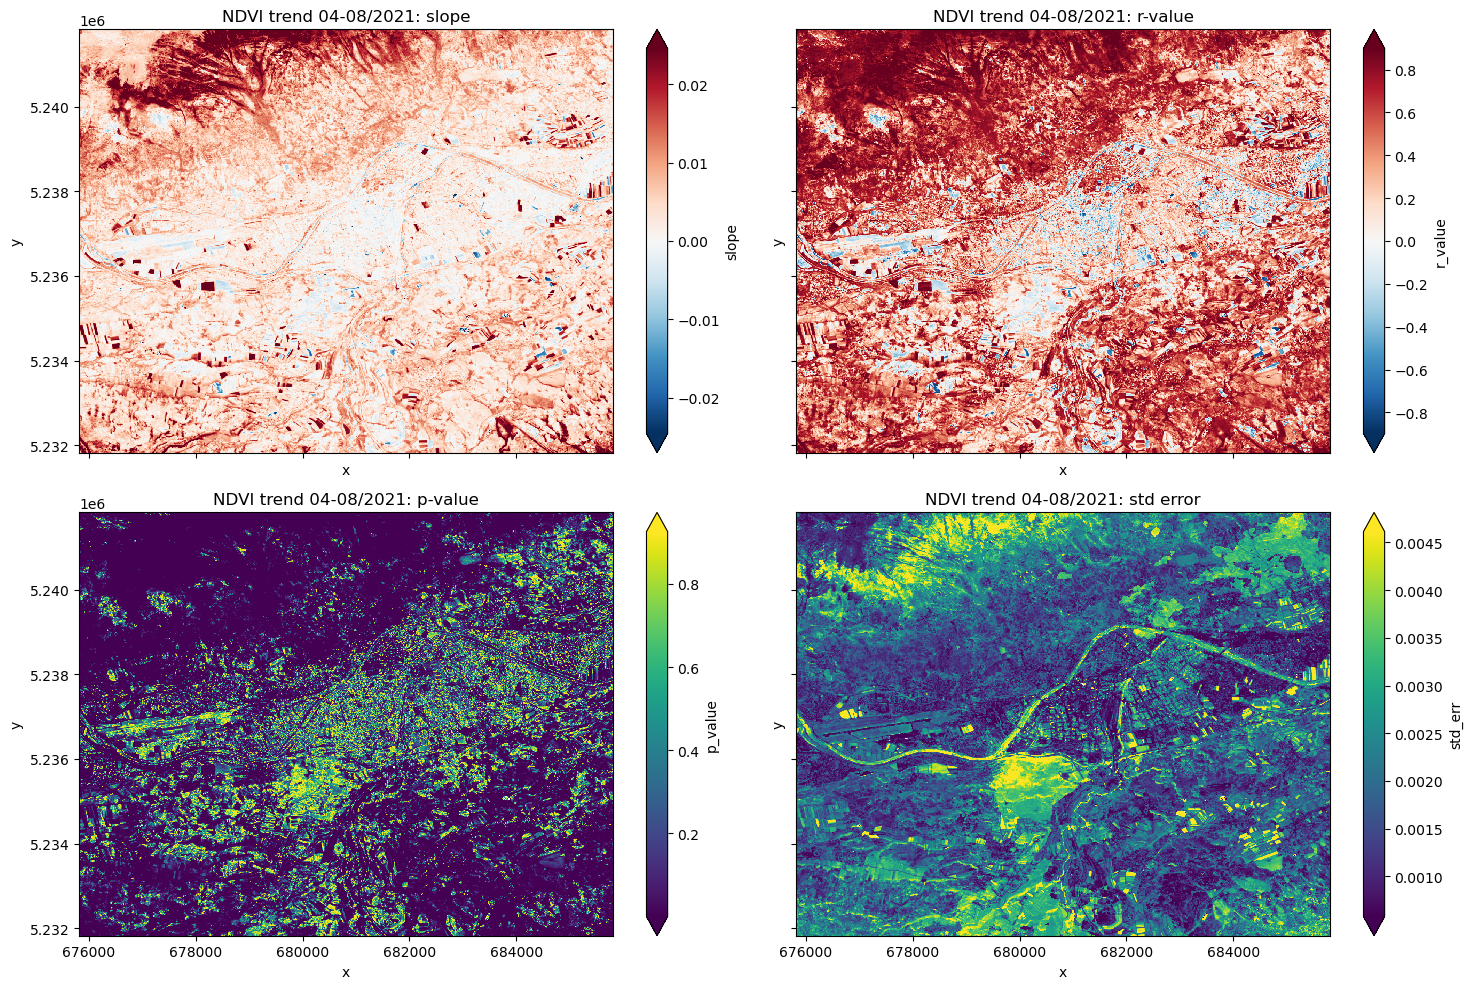

In [50]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(15,10), sharex=True, sharey=True)
NDVI_regressed.slope.plot(robust=True, ax=axes[0,0])
NDVI_regressed.r_value.plot(robust=True, ax=axes[0,1])
NDVI_regressed.p_value.plot(robust=True, ax=axes[1,0])
NDVI_regressed.std_err.plot(robust=True, ax=axes[1,1])
for ax, param in zip(axes.flat, ['slope', 'r-value', 'p-value', 'std error']):
    ax.set_title(f'NDVI trend 04-08/2021: {param}')
fig.tight_layout()

Create an interactive map to inspect the slope of the trend in more detail.

In [ ]:
import hvplot.xarray
import holoviews as hv
NDVI_regressed.slope.hvplot(x='x', y='y', aspect=1, clim=(-0.02,0.02), cmap="PRGn", title='NDVI slope April - Aug')

## Create an animation

Let's create an animation of our NDVI time series using the [xmovie](https://xmovie.readthedocs.io/en/latest/) package. We resample to weekly means of NDVI and interpolate missing values.

In [58]:
%%time
NDVI_weekly = NDVI.resample(time='1W').mean()
NDVI_weekly = NDVI_weekly.chunk(dict(time=-1))                        # rechunk into a single dask array chunk along the time dimension
NDVI_weekly = NDVI_weekly.interpolate_na(dim='time')

CPU times: total: 141 ms
Wall time: 149 ms


Now be patient while the movie is created.

In [59]:
%%time
from xmovie import Movie
mov = Movie(NDVI_weekly.chunk({'time':1}), dpi=100, vmin=-0.8, vmax=0.8, cmap="PRGn")

CPU times: total: 1min 15s
Wall time: 1min 2s


Use parallelization by Dask for saving the frames to an MP4 video clip (or a GIF). For this to work we have chunked the input DataArray with a single step along the dimension that represent our frames. Again be patient ... *(Code cell doesn't stop running even after video clip is saved!?)*

In [ ]:
%%time
mov.save(r'C:\work\etrainee\stac_exports\NDVI_animation.mp4', overwrite_existing=True, parallel=True, framerate=3)